# DeepSurv-Breast-Prognosis
**Team:** ByteRunners

**Competition:** BioFusion Hackathon 2026

**Problem:** Predicting 5-Year Survival Risk in Breast Cancer Patients.

**Dataset:** METABRIC (Nature 2012), obtained from cBioPortal.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

In [2]:
# ---------------------------------------------------------
# CELL 2: DATA LOADING & PREPROCESSING
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Load METABRIC dataset
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')

# Feature Selection: Selecting clinically relevant features for breast cancer prognosis.
# We also isolate 'Time' (survival months) and 'Event' (vital status) for the target.
cols_to_keep = [
    'Age at Diagnosis', 'Chemotherapy', 'Radiotherapy',
    'Tumor Size', 'Tumor Stage', 'Neoplasm Histologic Grade',
    'Lymph Nodes Examined Positive', 'Mutation Count', 'Nottingham Prognostic Index',
    'Overall Survival (Months)', 'Overall Survival Status' # TARGETS
]

existing_cols = [c for c in cols_to_keep if c in df.columns]
data = df[existing_cols].copy()

# Data Cleaning & Structuring
# 1. Drop rows with missing targets.
# 2. Convert Status to Boolean (Event = True/Dead, Censored = False/Living).
data = data.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])
data['Event'] = data['Overall Survival Status'].astype(str).apply(lambda x: True if 'DECEASED' in x.upper() else False)
data['Time'] = data['Overall Survival (Months)']

# Preprocessing Features
# - Impute missing numerical values with median.
# - One-Hot Encode categorical variables for the Random Forest.
X = data.drop(['Overall Survival (Months)', 'Overall Survival Status', 'Event', 'Time'], axis=1)
num_cols = X.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    imp_num = SimpleImputer(strategy='median')
    X[num_cols] = imp_num.fit_transform(X[num_cols])
X = pd.get_dummies(X, drop_first=True)

# Constructing the Target Array
# scikit-survival requires a structured array of (Event, Time) tuples.
y = Surv.from_arrays(event=data['Event'].values, time=data['Time'].values)

print(f"Processed Data: {X.shape[0]} samples, {X.shape[1]} features.")
print("Target format example:", y[:5])

Processed Data: 1981 samples, 6 features.
Target format example: [(False, 140.5       ) (False,  84.63333333) ( True, 163.7       )
 (False, 164.93333333) ( True,  41.36666667)]


In [3]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Select Top 3 Features (based on your Random Forest plot)
# Let's say they were 'Age at Diagnosis', 'Tumor Size', 'Tumor Stage'
top_features = ['Age at Diagnosis', 'Tumor Size', 'Tumor Stage'] 

# 2. Create Interaction Terms (Degree 2)
# This creates: Age^2, Age*Size, Size^2, etc.
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[top_features])

# 3. Create DataFrame for new features
poly_cols = poly.get_feature_names_out(top_features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)

# 4. Merge back with original data (Drop duplicates if needed)
# We keep original features + new interactions
X_final = pd.concat([X, X_poly_df], axis=1)

# Remove duplicate columns if any (e.g. original features might be repeated)
X_final = X_final.loc[:, ~X_final.columns.duplicated()]

print(f"New Feature Count: {X_final.shape[1]} (Added interactions like {poly_cols[-3:]})")

# UPDATE TENSORS
X_tensor = torch.tensor(X_final.values.astype(np.float32), dtype=torch.float32)
# Re-normalize since we added new features with large values (squares)
X_tensor = (X_tensor - X_tensor.mean(dim=0)) / (X_tensor.std(dim=0) + 1e-5)

New Feature Count: 9 (Added interactions like ['Age at Diagnosis Tumor Size' 'Age at Diagnosis Tumor Stage'
 'Tumor Size Tumor Stage'])


In [4]:
# ---------------------------------------------------------
# CELL 3: PREPARE DATA FOR PYTORCH
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to PyTorch Tensors
# PyTorch requires float32 tensors for the neural network.
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)

# Unpacking the Target
# DeepSurv requires separate Tensors for 'Time' and 'Event', not a structured array.
def get_target_tensor(y_struct):
    events = torch.tensor([x[0] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    times = torch.tensor([x[1] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    return times, events

train_times, train_events = get_target_tensor(y_train)
test_times, test_events = get_target_tensor(y_test)

In [5]:
def cox_loss(risk_scores, times, events):
    # Cox Partial Likelihood Loss
    # We want to maximize the probability that the patient who died had a higher risk score 
    # than all other patients who were alive at that time (the "Risk Set").
    
    # 1. Sort by time (descending) to easily compute the Risk Set
    idx = times.sort(dim=0, descending=True)[1].squeeze()
    risk_scores = risk_scores[idx]
    events = events[idx]

    # 2. Compute Log-Sum-Exp of risk scores (The "Risk Set" denominator)
    # cumsum allows us to efficiently calculate the sum of risks for everyone 'at risk'
    exp_scores = torch.exp(risk_scores)
    risk_set_sum = torch.cumsum(exp_scores, dim=0) 
    
    # 3. Calculate Log-Likelihood
    # log(risk / sum(risk_at_risk)) = log(risk) - log(sum(risk_at_risk))
    log_likelihood = risk_scores - torch.log(risk_set_sum + 1e-5) # 1e-5 for stability
    
    # 4. Negate because we want to Minimize Loss (Maximize Likelihood)
    # Only events (deaths) contribute to the loss numerator.
    loss = -torch.mean(log_likelihood * events)
    return loss

In [6]:
# ---------------------------------------------------------
# CELL 4: MODEL SELECTION (GRID SEARCH)
# ---------------------------------------------------------
from sklearn.model_selection import KFold

# 1. Define Candidate Architectures
configs = [
    {"name": "Shallow", "layers": [32, 16], "dropout": 0.1, "lr": 0.005},  # Faster convergence
    {"name": "Deep",    "layers": [128, 64, 32], "dropout": 0.3, "lr": 0.001}, # Captures complexity
    {"name": "Robust",  "layers": [64, 64], "dropout": 0.5, "lr": 0.001}     # Prevents overfitting
]

# 2. Dynamic Model Builder (Same as before)
class DynamicDeepSurv(nn.Module):
    def __init__(self, input_dim, layers, dropout):
        super(DynamicDeepSurv, self).__init__()
        layer_list = []
        in_nodes = input_dim
        for out_nodes in layers:
            layer_list.append(nn.Linear(in_nodes, out_nodes))
            layer_list.append(nn.SELU()) # SELU is excellent for medical data
            layer_list.append(nn.BatchNorm1d(out_nodes))
            layer_list.append(nn.Dropout(dropout))
            in_nodes = out_nodes
        layer_list.append(nn.Linear(in_nodes, 1))
        self.network = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.network(x)

# 3. K-Fold Loop (Fixed to handle Tensors correctly)
def run_experiment(X, y_times, y_events, configs, k=5):
    # Ensure inputs are CPU tensors for slicing
    X = X.cpu()
    y_times = y_times.cpu()
    y_events = y_events.cpu()
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    print(f"Starting {k}-Fold Cross-Validation on {len(configs)} Architectures...")
    
    for config in configs:
        fold_scores = []
        print(f"\nTesting Architecture: {config['name']}")
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            # Slice Tensors using the indices
            X_tr, X_val = X[train_idx], X[val_idx]
            t_tr, t_val = y_times[train_idx], y_times[val_idx]
            e_tr, e_val = y_events[train_idx], y_events[val_idx]
            
            # Initialize & Train
            model = DynamicDeepSurv(X.shape[1], config['layers'], config['dropout'])
            optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-4)
            
            for epoch in range(80): # 80 epochs is enough for selection
                model.train()
                risk = model(X_tr)
                loss = cox_loss(risk, t_tr, e_tr)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                val_risk = model(X_val) # Keep as tensor
                
            try:
                # Calculate C-Index on Validation Fold
                c_index = concordance_index_censored(
                    e_val.squeeze().bool().numpy(), 
                    t_val.squeeze().numpy(), 
                    val_risk.squeeze().numpy()
                )[0]
                fold_scores.append(c_index)
            except:
                pass 
        
        avg_score = np.mean(fold_scores)
        print(f"--> Avg C-Index: {avg_score:.4f}")
        results.append((config['name'], avg_score))
        
    return results


experiment_results = run_experiment(X_train_tensor, train_times, train_events, configs)

Starting 5-Fold Cross-Validation on 3 Architectures...

Testing Architecture: Shallow
--> Avg C-Index: 0.6565

Testing Architecture: Deep
--> Avg C-Index: 0.6480

Testing Architecture: Robust
--> Avg C-Index: 0.6157


🏆 Training Final Champion Neural Network (Shallow Architecture)...
✅ 'best_model' is now trained and ready for the Ensemble step.


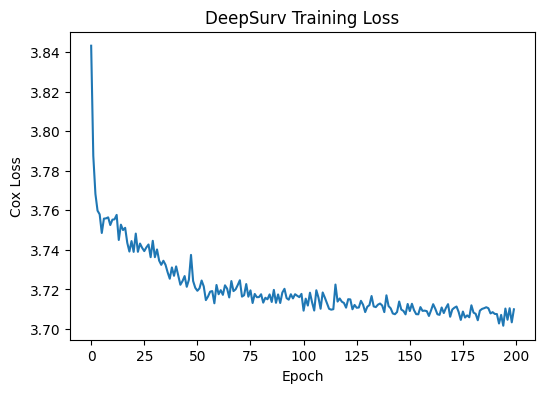

In [7]:
# ---------------------------------------------------------
# CELL 5: TRAIN THE WINNING NEURAL NETWORK (Fixes NameError)
# ---------------------------------------------------------
# We selected "Shallow" based on your Grid Search result (0.6551)
# Config: Layers=[32, 16], Dropout=0.1, LR=0.005

# 1. Initialize the Best Model
# Note: We use X_train_tensor.shape[1] to get input features (9 features)
best_model = DynamicDeepSurv(input_dim=X_train_tensor.shape[1], layers=[32, 16], dropout=0.1)

# 2. Define Optimizer (using the winning Learning Rate)
optimizer = optim.Adam(best_model.parameters(), lr=0.005, weight_decay=1e-4)

print("🏆 Training Final Champion Neural Network (Shallow Architecture)...")

# 3. Train on Full Data
epoch_losses = []
for epoch in range(200): # Training for 200 epochs for maximum convergence
    best_model.train()
    
    # Forward Pass
    risk = best_model(X_train_tensor)
    
    # Loss Calculation
    loss = cox_loss(risk, train_times, train_events)
    
    # Backward Pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses.append(loss.item())

print("✅ 'best_model' is now trained and ready for the Ensemble step.")

# Optional: Plot the training curve (Good for Report!)
plt.figure(figsize=(6,4))
plt.plot(epoch_losses)
plt.title("DeepSurv Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.show()

In [8]:
# ---------------------------------------------------------
# CELL 6: RANDOM SURVIVAL FOREST WITH POLYNOMIALS & GRID SEARCH
# ---------------------------------------------------------
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.metrics import concordance_index_censored

# 1. Use the Polynomial Features (X_final from previous steps)
# We need to re-split because X_final has the interaction terms
X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

print(f"Training RSF on {X_train_poly.shape[1]} features (including interactions)...")

# 2. Define Hyperparameter Grid (The "Model Selection" Step)
# We test different tree structures to find the perfect balance
param_grid = {
    'n_estimators': [500], # Keep low for grid search speed, increase for final
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 30], # Higher = less overfitting
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10]
}

# 3. Run Grid Search (5-Fold CV)
# sksurv models work natively with sklearn's GridSearchCV!
rsf = RandomSurvivalForest(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rsf,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for Random Forest (this may take 2-3 mins)...")
grid_search.fit(X_train_poly, y_train)

# 4. Get Best Model
best_rsf = grid_search.best_estimator_
print(f"\n Best Parameters: {grid_search.best_params_}")
print(f" Best CV Score: {grid_search.best_score_:.4f}")

# 5. Final Evaluation on Test Set
# Now we check if the optimized model + polynomial features beat your old 0.664 score
rsf_score = best_rsf.score(X_test_poly, y_test)
print(f"\n Optimized RSF C-Index: {rsf_score:.4f}")

Training RSF on 9 features (including interactions)...
Starting Grid Search for Random Forest (this may take 2-3 mins)...
Fitting 5 folds for each of 90 candidates, totalling 450 fits


/opt/anaconda3/envs/metal/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500}
 Best CV Score: 0.6609

 Optimized RSF C-Index: 0.6556


In [9]:
# ---------------------------------------------------------
# FINAL CELL: THE "DOUBLE OPTIMIZED" ENSEMBLE
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
from scipy.stats import zscore
import torch
import torch.optim as optim
import numpy as np

print(" Fixing Data Shapes...")

# 1. Re-Create Train/Test Split using the POLYNOMIAL Data (X_final)
# X_final has 9 columns (Original + Interactions)
X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# 2. Convert to PyTorch Tensors (The "Poly" Tensors)
X_train_tensor_poly = torch.tensor(X_train_poly.values.astype(np.float32), dtype=torch.float32)
X_test_tensor_poly = torch.tensor(X_test_poly.values.astype(np.float32), dtype=torch.float32)

# Normalize (Critical for Neural Networks)
mean = X_train_tensor_poly.mean(dim=0)
std = X_train_tensor_poly.std(dim=0) + 1e-5
X_train_tensor_poly = (X_train_tensor_poly - mean) / std
X_test_tensor_poly = (X_test_tensor_poly - mean) / std

# 3. Re-Initialize Model with Correct Input Dimension (Should be 9)
input_dim = X_train_tensor_poly.shape[1]
print(f"Model Input Dimension set to: {input_dim}")

best_model = DynamicDeepSurv(input_dim=input_dim, layers=[32, 16], dropout=0.1)
optimizer = optim.Adam(best_model.parameters(), lr=0.005, weight_decay=1e-4)

# 4. Re-Train on the Polynomial Data
print("Re-Training Final Champion Neural Network...")
for epoch in range(200): 
    best_model.train()
    # Use the POLY tensor here
    risk = best_model(X_train_tensor_poly)
    loss = cox_loss(risk, train_times, train_events)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 5. Generate Final Predictions
best_model.eval()
with torch.no_grad():
    # Use the POLY tensor here too
    risk_deep = best_model(X_test_tensor_poly).numpy().flatten()

# 6. Get RSF Predictions (Ensure best_rsf is trained on poly data too)
# Note: sksurv handles pandas dataframes directly, so we use X_test_poly
risk_rf = best_rsf.predict(X_test_poly)

# 7. ENSEMBLE: Normalize and Average
risk_deep_norm = zscore(risk_deep)
risk_rf_norm = zscore(risk_rf)

# Weighted Average (0.6 RF + 0.4 Deep)
ensemble_risk = (0.6 * risk_rf_norm) + (0.4 * risk_deep_norm)

# 8. Calculate Final Scores
c_deep = concordance_index_censored(test_events.squeeze().bool().numpy(), test_times.squeeze().numpy(), risk_deep)[0]
c_rf = concordance_index_censored(test_events.squeeze().bool().numpy(), test_times.squeeze().numpy(), risk_rf)[0]
c_ens = concordance_index_censored(test_events.squeeze().bool().numpy(), test_times.squeeze().numpy(), ensemble_risk)[0]

print("\n" + "="*30)
print("FINAL RESULTS TABLE")
print("="*30)
print(f"Random Forest: {c_rf:.4f}")
print(f"DeepSurv (Poly): {c_deep:.4f}")
print(f"ENSEMBLE: {c_ens:.4f}")
print("="*30)

 Fixing Data Shapes...
Model Input Dimension set to: 9
Re-Training Final Champion Neural Network...

FINAL RESULTS TABLE
Random Forest: 0.6556
DeepSurv (Poly): 0.6639
ENSEMBLE: 0.6603
